 - season： 1=春天，2=夏天，3=秋天，4=冬天
 -  holiday：1=该填假期
 - workingday：0=既不是假期也不是周末
 - weather：1=晴等较好的天气；2=薄雾，多云；
   3=小雪、小雨、暴风雨等天气；4=冰雹、暴雨、暴风雨+雾、雪+雾
  - temp：温度
  - atemp：体感温度
 - humidity：湿度
 -  windspeed：风强度
 - casual：没注册 
  - registered：注册了的 
  - count：租借数量

In [ ]:
import pandas as pd    #调库
import seaborn as sns
import calendar
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import calendar
from sklearn.model_selection import GridSearchCV

In [ ]:
#将训练、测试数据放入一个字典之中
dfs = {}
for name in ['train','test']:
    df = pd.read_csv('kaggle/input/%s.csv' % name)
    df['_data'] = name
    dfs[name] = df 

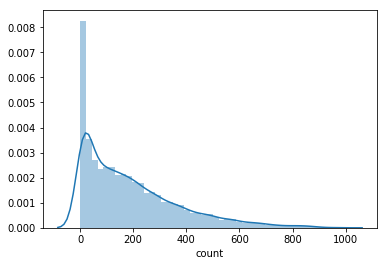

In [ ]:
#查看数据分布
sns.distplot(dfs['train']['count'])

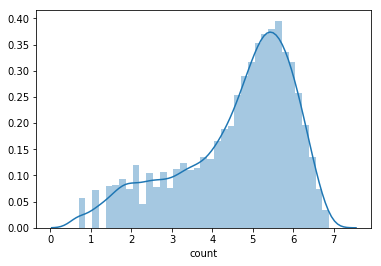

In [ ]:
#标签log化之后绘图，log化步骤是为了让数据分布更符合正态分布，之后方便标准处理
dfs['train']['count']=dfs['train']['count'].apply(lambda x:np.log(x+1))
sns.distplot(dfs['train']['count'])

In [ ]:
dt = pd.DatetimeIndex(dfs['train']['datetime'])
# 将一个时间信息完全拆分，一直分到秒
dfs['train'].set_index(dt, inplace=True)

dfs['train']['date'] = dt.date
dfs['train']['day'] = dt.day
dfs['train']['month'] = dt.month
dfs['train']['year'] = dt.year
dfs['train']['hour'] = dt.hour
dfs['train']['dow'] = dt.dayofweek
dfs['train']['woy'] = dt.weekofyear

[Text(0,0.5,'Count'),
 Text(0.5,0,'Month'),
 Text(0.5,1,'Box Plot On Count Across Month')]

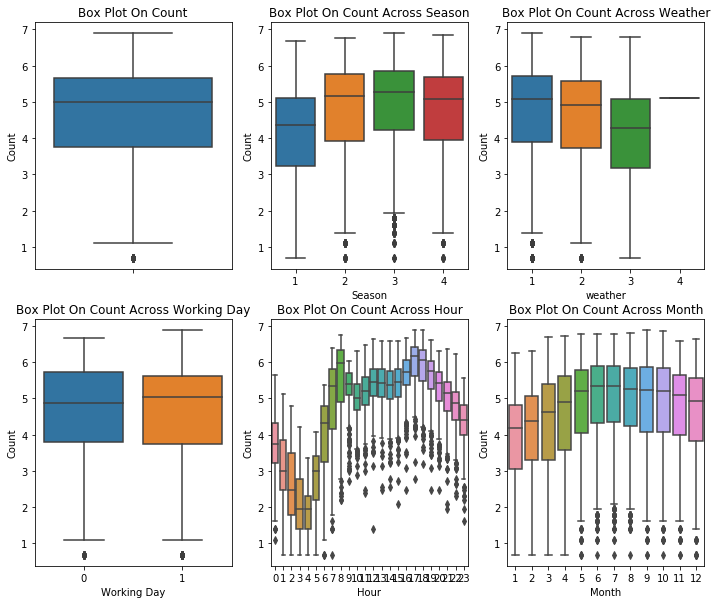

In [ ]:
#利用绘图进行异常值处理
fig, axes = plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(12, 10)
sns.boxplot(data=dfs['train'],y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=dfs['train'],y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=dfs['train'],y="count",x="weather",orient="v",ax=axes[0][2])
sns.boxplot(data=dfs['train'],y="count",x="workingday",orient="v",ax=axes[1][0])
sns.boxplot(data=dfs['train'],y="count",x="hour",orient="v",ax=axes[1][1])
sns.boxplot(data=dfs['train'],y="count",x="month",orient="v",ax=axes[1][2]) 
axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[0][2].set(xlabel='weather', ylabel='Count',title="Box Plot On Count Across Weather")
axes[1][0].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[1][1].set(xlabel='Hour', ylabel='Count',title="Box Plot On Count Across Hour")
axes[1][2].set(xlabel='Month', ylabel='Count',title="Box Plot On Count Across Month")

In [ ]:
#观察图像情况，发现数据存在异常点，这里进行删除
dfs['train'] = dfs['train'][np.abs(dfs['train']["count"]-dfs['train']["count"].mean())<=(3*dfs['train']["count"].std())]

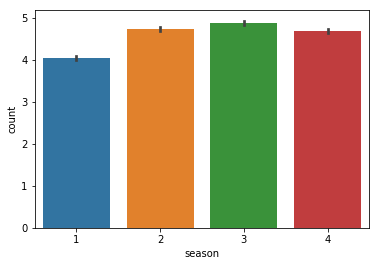

In [ ]:
#季节与结果的关系
sns.barplot(x = 'season' , y = 'count',data = dfs['train'])

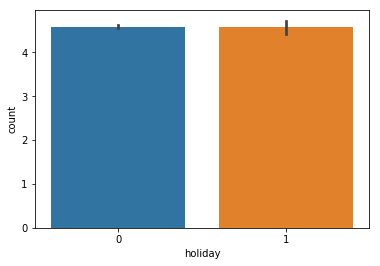

In [ ]:
#是否为假期与租车的关系
sns.barplot(x = 'holiday' , y = 'count',data = dfs['train'])

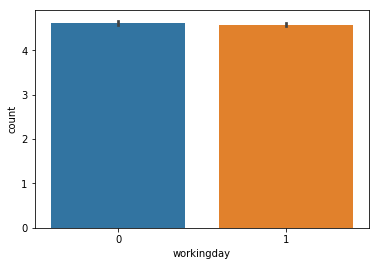

In [ ]:
#是否为工作日与租车的关系
sns.barplot(x = 'workingday' , y = 'count',data = dfs['train'])

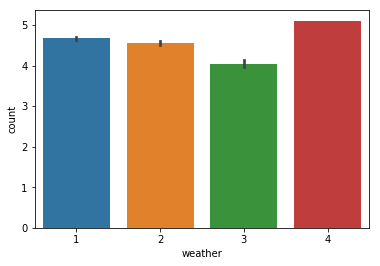

In [ ]:
#天气与租车的关系
sns.barplot(x = 'weather' , y = 'count',data = dfs['train'])

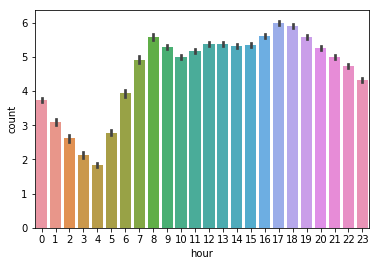

In [ ]:
#结果与小时的关系
sns.barplot(x = 'hour' , y = 'count',data = dfs['train'])

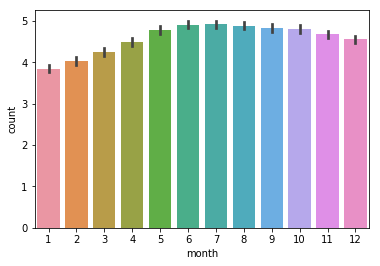

In [ ]:
#结果与月份的关系
sns.barplot(x = 'month' , y = 'count',data = dfs['train'])

In [ ]:
# 组合训练、测试集
df = dfs['train'].append(dfs['test'])

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [ ]:
# 训练的时候标签log化，log化步骤是为了让数据分布更符合正态分布，之后方便标准处理
for col in ['casual', 'registered']:#, 'count'
    df['%s_log' % col] = np.log(df[col] + 1)

In [ ]:
# 将一个时间信息完全拆分，一直分到秒
dt = pd.DatetimeIndex(df['datetime'])
df.set_index(dt, inplace=True)

df['date'] = dt.date
df['day'] = dt.day
df['month'] = dt.month
df['year'] = dt.year
df['hour'] = dt.hour
df['dow'] = dt.dayofweek
df['woy'] = dt.weekofyear

In [ ]:
#将工作日的早8、中午、晚6下班时间和非工作日的10-19点全部单独标记
df['peak'] = df[['hour', 'workingday']].apply(lambda x: (0, 1)
[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 13))
 or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)  

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  after removing the cwd from sys.path.


In [ ]:
#把数据集中未正常标记的节日也标记为假日
df['holiday'] = df[['month', 'day', 'holiday', 'year']].apply(lambda x: (x['holiday'], 1)
[x['year'] == 2012 and x['month'] == 10 and (x['day'] in [30])], axis = 1)

df['holiday'] = df[['month', 'day', 'holiday']].apply(lambda x: (x['holiday'], 1)
[x['month'] == 12 and (x['day'] in [24, 26, 31])], axis = 1)
df['workingday'] = df[['month', 'day', 'workingday']].apply(lambda x: (x['workingday'], 0)
[x['month'] == 12 and x['day'] in [24, 31]], axis = 1)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


In [ ]:
#标出理想出门天气
df['ideal'] = df[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
#标出很难出门的天气
df['sticky'] = df[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  after removing the cwd from sys.path.


In [ ]:
def get_rmsle(y_pred, y_actual):    #结果度量函数
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)
    
def get_data():    #得到训练集
    data = df[df['_data'] == 'train'].copy()
    return data

def custom_train_test_split(data, cutoff_day=15):    #自定义的训练、测试集划分，用于评估结果
    train = data[data['day'] <= cutoff_day]
    test = data[data['day'] > cutoff_day]

    return train, test

def prep_data(data, input_cols):    #返回特征与标签
    X = data[input_cols]
    y_r = data['registered_log']
    y_c = data['casual_log']

    return X, y_r, y_c
def predict_on_validation_set(model, input_cols):    #结果评估
    data = get_data()

    train, test = custom_train_test_split(data)

    X_train, y_train_r, y_train_c = prep_data(train, input_cols)
    X_test, y_test_r, y_test_c = prep_data(test, input_cols)

    model_r = model.fit(X_train, y_train_r)
    y_pred_r = np.exp(model_r.predict(X_test)) - 1#运算的时候结果指数化

    model_c = model.fit(X_train, y_train_c)
    y_pred_c = np.exp(model_c.predict(X_test)) - 1

    y_pred_comb = np.round(y_pred_r + y_pred_c)
    y_pred_comb[y_pred_comb < 0] = 0    #由于标签不可能是小于零的，这里做了这样的处理

    y_test_comb = np.exp(y_test_r) + np.exp(y_test_c) - 2

    score = get_rmsle(y_pred_comb, y_test_comb)
    return (y_pred_comb, y_test_comb, score)

df_test = df[df['_data'] == 'test'].copy()
def predict_on_test_set(model, x_cols):    #预测函数
    # prepare training set
    df_train = df[df['_data'] == 'train'].copy()
    X_train = df_train[x_cols]
    y_train_cas = df_train['casual_log']    #采用分开预测
    y_train_reg = df_train['registered_log']

    # prepare test set
    X_test = df_test[x_cols]

    casual_model = model.fit(X_train, y_train_cas)
    y_pred_cas = casual_model.predict(X_test)
    y_pred_cas = np.exp(y_pred_cas) - 1
    registered_model = model.fit(X_train, y_train_reg)
    y_pred_reg = registered_model.predict(X_test)
    y_pred_reg = np.exp(y_pred_reg) - 1
    # add casual & registered predictions together
    return y_pred_cas + y_pred_reg

    这里两个算法是分别使用的不同的特征

In [29]:
# random forest model
rf_cols = [#注意这里两个函数其实使用的是不同的属性值
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 'sticky',
    'hour', 'dow', 'woy', 'peak',
]
bes_p = {}
bes_sc = 100
#从500-1000搜决策树数量，从3-5搜最小分裂样本数
for n_est in range(500,1001,100):
    for min_s in range(3,6):
        params = {'n_estimators': n_est, 'min_samples_split' : min_s,'max_depth': 15, 'random_state': 0, 'n_jobs': -1}
        rf_model = RandomForestRegressor(**params)
        rf_p, rf_t, rf_score = predict_on_validation_set(rf_model, rf_cols)
        if rf_score<bes_sc:
            bes_p = params
            bes_sc = rf_score

In [19]:
#使用最佳参数用随机森林学习
rf_model = RandomForestRegressor(**bes_p)
rf_p, rf_t, rf_score = predict_on_validation_set(rf_model, rf_cols)
print('rf算法分数为:',rf_score)

rf算法分数为: 0.44110977580030325


In [20]:
# GBM model
gbm_cols = [#注意这里两个函数其实使用的是不同的属性值
    'weather', 'temp', 'atemp', 'humidity', 'windspeed',
    'holiday', 'workingday', 'season',
    'hour', 'dow', 'year', 'ideal'
    ]
bes_p2 = {}
bes_sc = 100
#从120-180搜决策树数量，从5-10搜最小样本叶值
for n_est in range(120,181,10):
    for min_l in range(5,11):
        params = {'n_estimators': n_est, 'max_depth': 5, 'random_state':
            0, 'min_samples_leaf' : min_l, 'learning_rate': 0.1, 'subsample': 0.7, 'loss': 'ls'}
        gbm_model = GradientBoostingRegressor(**params)
        rf_p, rf_t, rf_score = predict_on_validation_set(gbm_model, gbm_cols)
        if rf_score<bes_sc:
            bes_p2 = params
            bes_sc = rf_score

In [21]:
#用最佳参数使用gbm算法学习
gbm_model = GradientBoostingRegressor(**bes_p2)
(gbm_p, gbm_t, gbm_score) = predict_on_validation_set(gbm_model, gbm_cols)
print('gmb算法的分数:',gbm_score)

gmb算法的分数: 0.31766837045204616


In [24]:
# 集成能够得到一个更好的结果
y_p = np.round(.2*rf_p + .8*gbm_p)
print('最终分数：',get_rmsle(y_p, rf_t))

最终分数： 0.317462906347344


In [25]:
# 算出预测结果
rf_pred = predict_on_test_set(rf_model, rf_cols)
gbm_pred = predict_on_test_set(gbm_model, gbm_cols)

In [26]:
#用两个模型加权得出结果
y_pred = np.round(.20*rf_pred + .80*gbm_pred)

In [27]:
#输出提交
df_test['count'] = y_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('output5.csv', index=False)

In [28]:
print('最终标签如下\n',final_df)

最终标签如下
                                 datetime  count
datetime                                       
2011-01-20 00:00:00  2011-01-20 00:00:00   12.0
2011-01-20 01:00:00  2011-01-20 01:00:00    5.0
2011-01-20 02:00:00  2011-01-20 02:00:00    3.0
2011-01-20 03:00:00  2011-01-20 03:00:00    2.0
2011-01-20 04:00:00  2011-01-20 04:00:00    2.0
2011-01-20 05:00:00  2011-01-20 05:00:00    8.0
2011-01-20 06:00:00  2011-01-20 06:00:00   37.0
2011-01-20 07:00:00  2011-01-20 07:00:00  121.0
2011-01-20 08:00:00  2011-01-20 08:00:00  247.0
2011-01-20 09:00:00  2011-01-20 09:00:00  132.0
2011-01-20 10:00:00  2011-01-20 10:00:00   69.0
2011-01-20 11:00:00  2011-01-20 11:00:00   70.0
2011-01-20 12:00:00  2011-01-20 12:00:00   84.0
2011-01-20 13:00:00  2011-01-20 13:00:00   82.0
2011-01-20 14:00:00  2011-01-20 14:00:00   76.0
2011-01-20 15:00:00  2011-01-20 15:00:00   79.0
2011-01-20 16:00:00  2011-01-20 16:00:00   98.0
2011-01-20 17:00:00  2011-01-20 17:00:00  184.0
2011-01-20 18:00:00  2011-01-20 

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 